# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from benchmarks.railway import Solution, RevenueMaximization
from src.entities import GSA

from typing import List, Mapping, Union

## 1. Define corridor

As an example, we will use the Spanish south high-speed railway corridor.



In [2]:
# Define corridor

corridor = {"MAD": {
                "CIU": {
                    "COR": {
                        "SEV": {
                            "CAD": {}
                               },
                        "PGE": {
                            "ANT": {
                                "GRA": {},
                                "MAL": {}
                                    }
                                }
                            }
                        }
                    }
            }

### 1.1. Get lines from corridor

In [3]:
# Get lines from corridor

def get_lines(corridor: Mapping[str, Mapping],
              path: Union[List, None]=None
              ) -> List[List[str]]:
    """
    Get all the lines in the corridor
    
    Args:
        corridor (dict): dictionary with the corridor structure
        path (list, optional): list of nodes
    
    Returns:
        list of lines
    """
    if path is None:
        path = []

    lines = []
    for node, child in corridor.items():
        new_path = path + [node]
        if not child:  # If the node has no children, it is a leaf
            lines.append(new_path)
        else:
            lines.extend(get_lines(child, new_path))  # If the node has children, we call the function recursively

    return lines

get_lines(corridor)

[['MAD', 'CIU', 'COR', 'SEV', 'CAD'],
 ['MAD', 'CIU', 'COR', 'PGE', 'ANT', 'GRA'],
 ['MAD', 'CIU', 'COR', 'PGE', 'ANT', 'MAL']]

### 1.2. Sample a random line, and a random route from the line

In [4]:
def sample_line(lines: list) -> list:
    """
    Sample a random line from the list of lines
    
    Args:
        lines (list): list of lines
    
    Returns:
        list: random line
    """
    return lines[np.random.randint(len(lines))] 

def sample_route(line: list) -> list:
    """
    Sample a random route from line
    
    Args:
        line (list): list of stations
        
    Returns:
        list: random route
    """
    return line[np.random.randint(0, len(line)-1):]

lines = get_lines(corridor)

line = sample_line(lines)
print(f"Sampled line: {line}")

# Sample a random route from line (at least two stations)
route = sample_route(line)
print(f"Sampled route: {route}")

Sampled line: ['MAD', 'CIU', 'COR', 'PGE', 'ANT', 'MAL']
Sampled route: ['ANT', 'MAL']


### 1.3 Generate random timetable for a route

- Times in minutes.
- Initial time is randomized between 0 and 24*60 (24 hours).
- The time between stations is also randomized between 30 and 120 minutes.
- The time to dwell at each station is randomized between 2 and 8 minutes.

In [5]:
def get_timetable(route: list) -> dict:
    """
    Generate random timetable for route r
    
    Args:
        route (list): list of stations
    
    Returns:
        dict: timetable
    """
    timetable = {}
    AT = np.random.randint(0, 24*60)
    DT = AT
    for i, sta in enumerate(route):
        if i == 0 or i == len(route)-1:
            timetable[sta] = (AT, AT)
        else:
            timetable[sta] = (AT, DT)
            
        AT += np.random.randint(30, 120)
        DT = AT + np.random.randint(2, 8)
        
    return timetable

get_timetable(route)

{'ANT': (330, 330), 'MAL': (400, 400)}

## 2. Generate as many requested services as needed

In [6]:
# Generate random requested timetable in corridor for a day t

def get_schedule_request(n_services: int) -> dict:
    """
    Generate random timetable
    
    Args:
        n_services (int): number of services
    
    Returns:
        dict: timetable
    """
    return {i: get_timetable(sample_route(sample_line(lines))) for i in range(1, n_services+1)}

# Generate random schedule
schedule = get_schedule_request(3)
schedule

{1: {'ANT': (221, 221), 'GRA': (286, 286)},
 2: {'SEV': (1348, 1348), 'CAD': (1382, 1382)},
 3: {'CIU': (1291, 1291),
  'COR': (1374, 1379),
  'SEV': (1448, 1453),
  'CAD': (1542, 1542)}}

## 3. Define feasibility function

In [336]:
schedule = get_schedule_request(12)
schedule

{1: {'MAD': (1222, 1222),
  'CIU': (1277, 1279),
  'COR': (1352, 1354),
  'PGE': (1456, 1463),
  'ANT': (1528, 1535),
  'GRA': (1570, 1570)},
 2: {'CIU': (920, 920),
  'COR': (1019, 1024),
  'PGE': (1136, 1139),
  'ANT': (1194, 1198),
  'MAL': (1250, 1250)},
 3: {'COR': (1056, 1056), 'SEV': (1128, 1132), 'CAD': (1198, 1198)},
 4: {'COR': (1364, 1364), 'SEV': (1407, 1412), 'CAD': (1488, 1488)},
 5: {'MAD': (50, 50),
  'CIU': (137, 143),
  'COR': (201, 203),
  'PGE': (320, 323),
  'ANT': (389, 394),
  'MAL': (494, 494)},
 6: {'ANT': (703, 703), 'GRA': (756, 756)},
 7: {'PGE': (844, 844), 'ANT': (946, 949), 'GRA': (998, 998)},
 8: {'PGE': (347, 347), 'ANT': (431, 435), 'GRA': (489, 489)},
 9: {'PGE': (39, 39), 'ANT': (134, 137), 'MAL': (247, 247)},
 10: {'COR': (564, 564), 'SEV': (597, 599), 'CAD': (665, 665)},
 11: {'CIU': (1193, 1193),
  'COR': (1275, 1281),
  'SEV': (1365, 1372),
  'CAD': (1467, 1467)},
 12: {'MAD': (715, 715),
  'CIU': (811, 813),
  'COR': (850, 856),
  'PGE': (884, 8

In [277]:
# Dummy schedule
schedule = {1: {'MAD': (0, 0), 'BAR': (148, 152), 'FIG': (180, 180)},
            2: {'MAD': (8, 8), 'ZAR': (28, 30), 'BAR': (165, 167), 'FIG': (210, 210)},
            3: {'MAD': (30, 30), 'BAR': (180, 182), 'FIG': (225, 225)}}

In [337]:
from scipy.stats import loguniform

np.random.seed(seed=22)

def get_revenue_behaviour(schedule: dict) -> dict:
    """
    Get revenue behaviour
    
    Args:
        schedule (dict): schedule
    
    Returns:
        dict: revenue behaviour
    """
    revenue = {}
    bias = [0.2, 0.35, 0.1]
    for service in schedule:
        b = np.random.choice(bias)
        base_price = 55 * len(schedule[service])
        canon = base_price + b * base_price
        k = loguniform.rvs(0.01, 100, 1)
        max_penalty = canon * 0.4
        dt_penalty = max_penalty * 0.35
        tt_penalty = (max_penalty - dt_penalty) / (len(schedule[service]) - 1)
        revenue[service] = {'canon': canon, 'k': k, 'dt_max_penalty': dt_penalty, 'tt_max_penalty': tt_penalty}
    return revenue

revenue = get_revenue_behaviour(schedule)
revenue

{1: {'canon': 445.5,
  'k': 7.424686268142557,
  'dt_max_penalty': 62.370000000000005,
  'tt_max_penalty': 23.166000000000004},
 2: {'canon': 330.0,
  'k': 1.4810078247291318,
  'dt_max_penalty': 46.199999999999996,
  'tt_max_penalty': 21.450000000000003},
 3: {'canon': 181.5,
  'k': 14.186717826602765,
  'dt_max_penalty': 25.41,
  'tt_max_penalty': 23.595000000000006},
 4: {'canon': 198.0,
  'k': 1.2267022562285983,
  'dt_max_penalty': 27.72,
  'tt_max_penalty': 25.740000000000002},
 5: {'canon': 445.5,
  'k': 1.0868061734082222,
  'dt_max_penalty': 62.370000000000005,
  'tt_max_penalty': 23.166000000000004},
 6: {'canon': 132.0,
  'k': 1.0761409106241633,
  'dt_max_penalty': 18.48,
  'tt_max_penalty': 34.32000000000001},
 7: {'canon': 181.5,
  'k': 17.174998340882127,
  'dt_max_penalty': 25.41,
  'tt_max_penalty': 23.595000000000006},
 8: {'canon': 181.5,
  'k': 2.7571740730038656,
  'dt_max_penalty': 25.41,
  'tt_max_penalty': 23.595000000000006},
 9: {'canon': 198.0,
  'k': 1.02269

In [338]:
sm = RevenueMaximization(schedule, revenue, safe_headway=10)

In [258]:
# Dummy schedule
schedule = {1: {'MAD': (0, 0), 'BAR': (148, 152), 'FIG': (180, 180)},
            2: {'MAD': (8, 8), 'ZAR': (28, 30), 'BAR': (165, 167), 'FIG': (210, 210)},
            3: {'MAD': (30, 30), 'BAR': (180, 182), 'FIG': (225, 225)}}

In [ ]:
sm.update_schedule(Solution(real=np.array([-3, 152, 8, 30, 167, 30, 182], dtype=float), discrete=np.array([])))
sm.updated_schedule

In [268]:
sm.get_real_vars()

([575,
  890,
  978,
  1055,
  1081,
  384,
  429,
  1020,
  1340,
  1446,
  1528,
  1621,
  1366,
  1463,
  1565,
  1609,
  878,
  1029,
  161,
  220,
  305,
  374,
  412,
  479,
  1260,
  1361,
  1413,
  1456,
  193,
  291],
 [(565, 585),
  (880, 900),
  (240.0, 988),
  (85.0, 1065),
  (56.0, 1091),
  (374, 394),
  (75.0, 439),
  (1010, 1030),
  (1330, 1350),
  (1446, 1456),
  (1528, 1538),
  (1621, 1631),
  (1356, 1376),
  (1463, 1473),
  (1565, 1575),
  (1609, 1619),
  (868, 888),
  (1019, 1039),
  (151, 171),
  (220, 230),
  (295, 315),
  (374, 384),
  (412, 422),
  (479, 489),
  (1250, 1270),
  (1361, 1371),
  (1413, 1423),
  (1456, 1466),
  (183, 203),
  (291, 301)])

In [269]:
sm.real_boundaries

[(565, 585),
 (880, 900),
 (978, 988),
 (1055, 1065),
 (1081, 1091),
 (374, 394),
 (429, 439),
 (1010, 1030),
 (1330, 1350),
 (1446, 1456),
 (1528, 1538),
 (1621, 1631),
 (1356, 1376),
 (1463, 1473),
 (1565, 1575),
 (1609, 1619),
 (868, 888),
 (1019, 1039),
 (151, 171),
 (220, 230),
 (295, 315),
 (374, 384),
 (412, 422),
 (479, 489),
 (1250, 1270),
 (1361, 1371),
 (1413, 1423),
 (1456, 1466),
 (183, 203),
 (291, 301)]

In [339]:
gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
               is_feasible=sm.feasible_services_times,
               r_dim=len(sm.real_boundaries),
               d_dim=0,
               boundaries=sm.boundaries)

In [340]:
import cProfile as profile
import time

pr = profile.Profile()
pr.disable()

gsa_algo.set_seed(seed=28)

pop_size = 5

start = time.time()
pr.enable()
training_history = gsa_algo.optimize(population_size=pop_size,
                                     iters=50,
                                     chaotic_constant=True,
                                     repair_solution=False,
                                     initial_population=sm.get_initial_population(pop_size))
pr.disable()
print(f"Elapsed time: {time.time() - start}")

pr.dump_stats('profile.pstat')

Initial population: [<src.entities.Solution object at 0x15f47c100>, <src.entities.Solution object at 0x177d31e20>, <src.entities.Solution object at 0x2c1608fa0>, <src.entities.Solution object at 0x2c1608880>, <src.entities.Solution object at 0x2c1608220>]
GSA is optimizing  "get_fitness_gsa"
['At iteration 1 the best fitness is 1501.3568273666833']
['At iteration 2 the best fitness is 1501.3568273666833']
['At iteration 3 the best fitness is 1501.3568273666833']
['At iteration 4 the best fitness is 1501.3568273666833']
['At iteration 5 the best fitness is 1501.3568273666833']
['At iteration 6 the best fitness is 1501.3568273666833']
['At iteration 7 the best fitness is 1501.3568273666833']
['At iteration 8 the best fitness is 1501.3568273666833']
['At iteration 9 the best fitness is 1501.3568273666833']
['At iteration 10 the best fitness is 1501.3568273666833']
['At iteration 11 the best fitness is 1501.3568273666833']
['At iteration 12 the best fitness is 1501.3568273666833']
['At ite

In [341]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,1501.356827,0,1.771814,[],"[1219.42, 1279.05, 1357.26, 1467.65, 1541.84, ..."
1,1,1501.356827,0,3.522415,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
2,2,1501.356827,0,5.344829,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
3,3,1501.356827,0,7.241840,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
4,4,1501.356827,0,9.087715,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
5,5,1501.356827,0,10.988446,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
6,6,1501.356827,0,12.838945,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
7,7,1501.356827,0,14.693973,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
8,8,1501.356827,0,16.603606,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."
9,9,1501.356827,0,18.448293,[],"[1229.375036032176, 1302.9007377062167, 1372.9..."


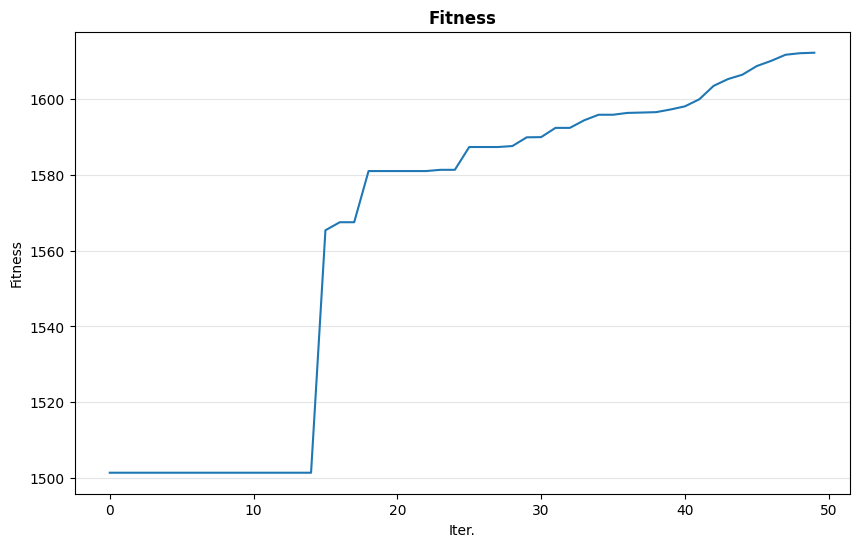

In [342]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=training_history,
             x="Iteration",
             y="Fitness",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fuclm%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat


In [12]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,517.014978,0,0.003048,[],"[-4.98, 157.83, 161.92, 189.92, 11.98, 35.76, ..."
1,1,530.855183,0,0.085591,[],"[-2.7546657683245406, 157.40093372659027, 161...."
2,2,542.646939,0,0.165635,[],"[-1.4908902847345742, 157.03956686173672, 161...."
3,3,565.661258,0,0.218120,[],"[-0.08372446694929914, 152.02590705979338, 157..."
4,4,565.661258,0,0.242157,[],"[5.670225709399254, 148.90734406439034, 159.04..."
5,5,565.661258,0,0.312635,[],"[5.670225709399254, 148.90734406439034, 159.04..."
6,6,565.661258,0,0.359963,[],"[5.670225709399254, 148.90734406439034, 159.04..."
7,7,566.497557,0,0.363831,[],"[-9.771727430351225, 145.23158773598314, 153.9..."
8,8,568.721232,0,0.367587,[],"[-7.794995179434571, 143.10007102447446, 154.2..."
9,9,568.721232,0,0.370925,[],"[-9.92970600467806, 143.22751590497882, 153.84..."


In [13]:
# Get last value in column 'Real' of training_history
best_solution = training_history.iloc[-1]['Real']

In [16]:
sm.update_feasible_schedules(Solution(real=np.array(best_solution, dtype=float), discrete=np.array([])))
sm.feasible_schedules

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

In [17]:
S_i = sm.get_best_schedule(Solution(real=best_solution, discrete=np.array([])))
print(S_i)

sm.get_revenue(Solution(real=best_solution, discrete=S_i))

[1 1 1]


591.2527108040338

In [18]:
sm.get_best_schedule(Solution(real=best_solution, discrete=np.array([])))

array([1, 1, 1])

In [19]:
sum([revenue[service]['canon'] for service in revenue])

668.25

In [20]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,517.014978,0,0.003048,[],"[-4.98, 157.83, 161.92, 189.92, 11.98, 35.76, ..."
1,1,530.855183,0,0.085591,[],"[-2.7546657683245406, 157.40093372659027, 161...."
2,2,542.646939,0,0.165635,[],"[-1.4908902847345742, 157.03956686173672, 161...."
3,3,565.661258,0,0.218120,[],"[-0.08372446694929914, 152.02590705979338, 157..."
4,4,565.661258,0,0.242157,[],"[5.670225709399254, 148.90734406439034, 159.04..."
5,5,565.661258,0,0.312635,[],"[5.670225709399254, 148.90734406439034, 159.04..."
6,6,565.661258,0,0.359963,[],"[5.670225709399254, 148.90734406439034, 159.04..."
7,7,566.497557,0,0.363831,[],"[-9.771727430351225, 145.23158773598314, 153.9..."
8,8,568.721232,0,0.367587,[],"[-7.794995179434571, 143.10007102447446, 154.2..."
9,9,568.721232,0,0.370925,[],"[-9.92970600467806, 143.22751590497882, 153.84..."
